In [1]:
# model implementation
from ml.models.clustering import KNN
from ml.functions.distance import EuclideanDistance, MahalanobisDistance

# model selection
from ml.model_selection import GridSearchCV
from ml.functions.metrics.classification import F1Score, BinaryAccuracy
from ml.stats import ClassificationStats

# data manipulation
from ml.dataset import load_csv, split_train_test
from ml.algorithms.normalization import MinMaxScaler

# Utility
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier

np.random.seed(20)

## Load dataset

In [2]:
# X, y = load_csv('./datasets/kc2.csv', remove_duplicates=True, remove_inconsistent_labels=True)
X, y = load_csv('./datasets/kc2.csv')

y = y.astype(int).squeeze()
X_train, y_train, X_test, y_test = split_train_test(X, y, 0.8, shuffle=True)

## Q1 a,b - K-Nearest Neighbors (KNN)

### Grid search with 10-fold cross-validation - hyperparameters K=[1, 5] and distance=['Euclidean', 'Mahalanobis']

In [7]:
grid = GridSearchCV(stats_generator=ClassificationStats)

for k in [1, 5]:
    for distance in [EuclideanDistance, MahalanobisDistance]:
        grid.add(KNN, {"k": k, "distance": distance, "data_scaler": MinMaxScaler})
        grid.add(KNN, {"k": k, "distance": distance, "data_scaler": MinMaxScaler})

grid.search(X_train, y_train, num_folds=10, score=F1Score(), score_minimize=False, shuffle=False)
print("Best KNN:", grid.best_model_params)

Best KNN: {'k': 5, 'distance': <class 'ml.functions.distance.EuclideanDistance'>, 'data_scaler': <class 'ml.algorithms.normalization.MinMaxScaler'>}


### Performance of the best model on the **test** dataset

In [8]:
knnX = grid.best_model(**grid.best_model_params)
knnX.fit(X_train, y_train)

y_pred = knnX.predict(X_test)

print("Accuracy:", BinaryAccuracy().measure(y_test, y_pred))
print("F1-score:", F1Score().measure(y_test, y_pred))

Accuracy: 0.8380952380952381
F1-score: 0.6382978723404256


### Performance of SKLearn's implmentation with parameters of the best model

In [5]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit(X_train).transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn5_sk = KNeighborsClassifier(n_neighbors=1, p=2, algorithm='brute')
knn5_sk.fit(X_train, y_train)

y_pred_sk = knn5_sk.predict(X_test)

print("SK-Learn's KNN5 Accuracy:", BinaryAccuracy().measure(y_test, y_pred_sk))
print("SK-Learn's KNN5 F1-score:", F1Score().measure(y_test, y_pred_sk))

SK-Learn's KNN5 Accuracy: 0.7333333333333333
SK-Learn's KNN5 F1-score: 0.391304347826087


### Report K-fold mean +- standard deviation for: F1-score, Accuracy, Recall and Precision

F1
	K=1, Euclid. (ours): 0.34133069828722 +- 0.10887563909591992
	K=1, Mahal. (ours): 0.31858695652173913 +- 0.08004368939803394
	K=1, Euclid. (sklearn): 0.3782119514472456 +- 0.11370340987264965
	K=5 Euclid. (ours): 0.43449725369230013 +- 0.16319742186288475
	K=5 Mahal. (ours): 0.4123443223443224 +- 0.23794664565852702
	K=5, Euclid. (sklearn): 0.481045751633987 +- 0.21357451641288322
RECALL
	K=1, Euclid. (ours): 0.4544264069264069 +- 0.1447968274288643
	K=1, Mahal. (ours): 0.39896103896103896 +- 0.11696168595456669
	K=1, Euclid. (sklearn): 0.38467532467532467 +- 0.13384970255869166
	K=5 Euclid. (ours): 0.38106421356421355 +- 0.19753175312608093
	K=5 Mahal. (ours): 0.319505772005772 +- 0.2164870098898964
	K=5, Euclid. (sklearn): 0.4228968253968254 +- 0.21656436266913529
PRECISION
	K=1, Euclid. (ours): 0.2858134757399463 +- 0.10523390258578474
	K=1, Mahal. (ours): 0.280009435009435 +- 0.09212983430355487
	K=1, Euclid. (sklearn): 0.41290764790764795 +- 0.1887074687640289
	K=5 Euclid. (ou

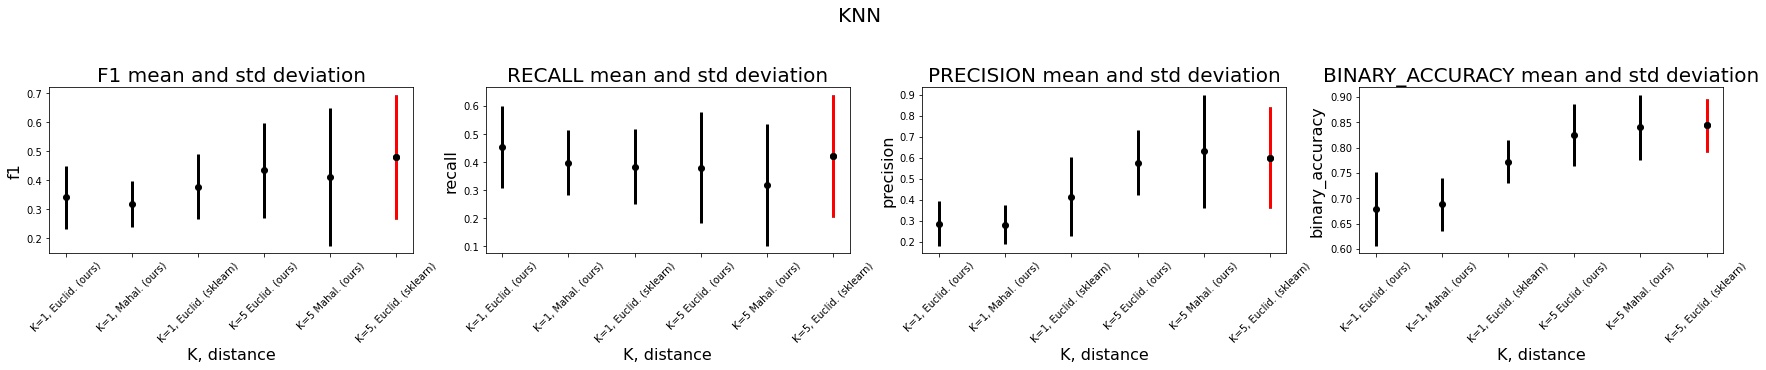

In [6]:
candidates = ["K=1, Euclidean", "K=1, Mahalanobis", "K=5 Euclidean", "K=5 Mahalanobis"]
num_candidates = len(grid.candidates)
k=0
plt.figure(figsize=(30, 4))
plt.suptitle("KNN", fontsize=20)
plt.subplots_adjust(top=0.7)
for metric in ['f1', 'recall', 'precision', 'binary_accuracy']:
    means = []
    std = []
    
    for i in range(num_candidates):
        means.append(np.mean(grid.stats[i].stats["values"][metric]))
        std.append(np.std(grid.stats[i].stats["values"][metric]))

    plt.subplot(1, 4, k+1)
    plt.errorbar(np.arange(num_candidates), means, std, fmt='ok', lw=3)
    plt.errorbar(grid.index_of_best, means[grid.index_of_best], std[grid.index_of_best], ecolor='red', fmt='ok', lw=3)
    
    plt.title(metric.upper() + " mean and std deviation", fontsize=20)
    plt.xticks(np.arange(num_candidates), labels=candidates, rotation=45)
    plt.xlabel("K, distance", fontsize=16)
    plt.ylabel(metric, fontsize=16)

    print(metric.upper())
    for c in range(num_candidates):
        print(f"\t{candidates[c]}:", means[c], "+-", std[c])
    
    k+=1